The ionosphere (low frequency) is a layer in the GUNW and we just compare its phase to the unwrapped phase. The ionosphere correction is thanks to Marin Gorvorcin. The plots are how Marin has shared this data previously.

In [1]:
import rasterio
from pathlib import Path
import matplotlib.pyplot as plt
from dem_stitcher.rio_tools import reproject_arr_to_match_profile
from rasterio.plot import show
import numpy as np

In [2]:
job_name = 'Marrakesh-0_45_None_0915_noFr'#"Marrakesh-1_154_None_0911_noFr" # "Marrakesh-1_154_None_0911"

In [3]:
prod_dir = Path(f'products/{job_name}')
assert(prod_dir.exists())

In [4]:
gunw_paths = sorted(list(prod_dir.glob('*.nc')))
gunw_paths[-1]

PosixPath('products/Marrakesh-0_45_None_0915_noFr/S1-GUNW-A-R-045-tops-20230915_20230903-183345-00009W_00029N-PP-3046-v3_0_0.nc')

In [5]:
iono_var = '/science/grids/corrections/derived/ionosphere/ionosphere'
iono_burst_var = '/science/grids/corrections/derived/ionosphereBurstRamps/ionosphereBurstRamps'

unw_var = '/science/grids/data/unwrappedPhase'

# Loading Data

In [6]:
# an easy way to inspect different products downloaded
# Change this index to see different products
product_index = 0

In [7]:
def open_one(path: Path, var: str) -> tuple:
    with rasterio.open(f'netcdf:{path}:{var}') as ds:
        X = ds.read(1)
        p = ds.profile
    return X, p

In [8]:
unw, p_unw = open_one(gunw_paths[product_index], unw_var)
unw[unw == 0] = np.nan
unw = unw - np.nanmean(unw)

ion, p_ion = open_one(gunw_paths[product_index], iono_var)
ion = ion - np.nanmean(ion)
ion_r, p_ion_r = reproject_arr_to_match_profile(ion, p_ion, p_unw)
ion_r = ion_r[0, ...]

ion_b, p_ion_b = open_one(gunw_paths[product_index], iono_burst_var)
ion_b = ion_b - np.nanmean(ion_b)
ion_b_r, p_ion_r = reproject_arr_to_match_profile(ion_b, p_ion_b, p_unw)
ion_b_r = ion_b_r[0, ...]

# Ionosphere

In [9]:
corr = ion_b_r # + ion_r

Text(0, 0.5, 'Radians')

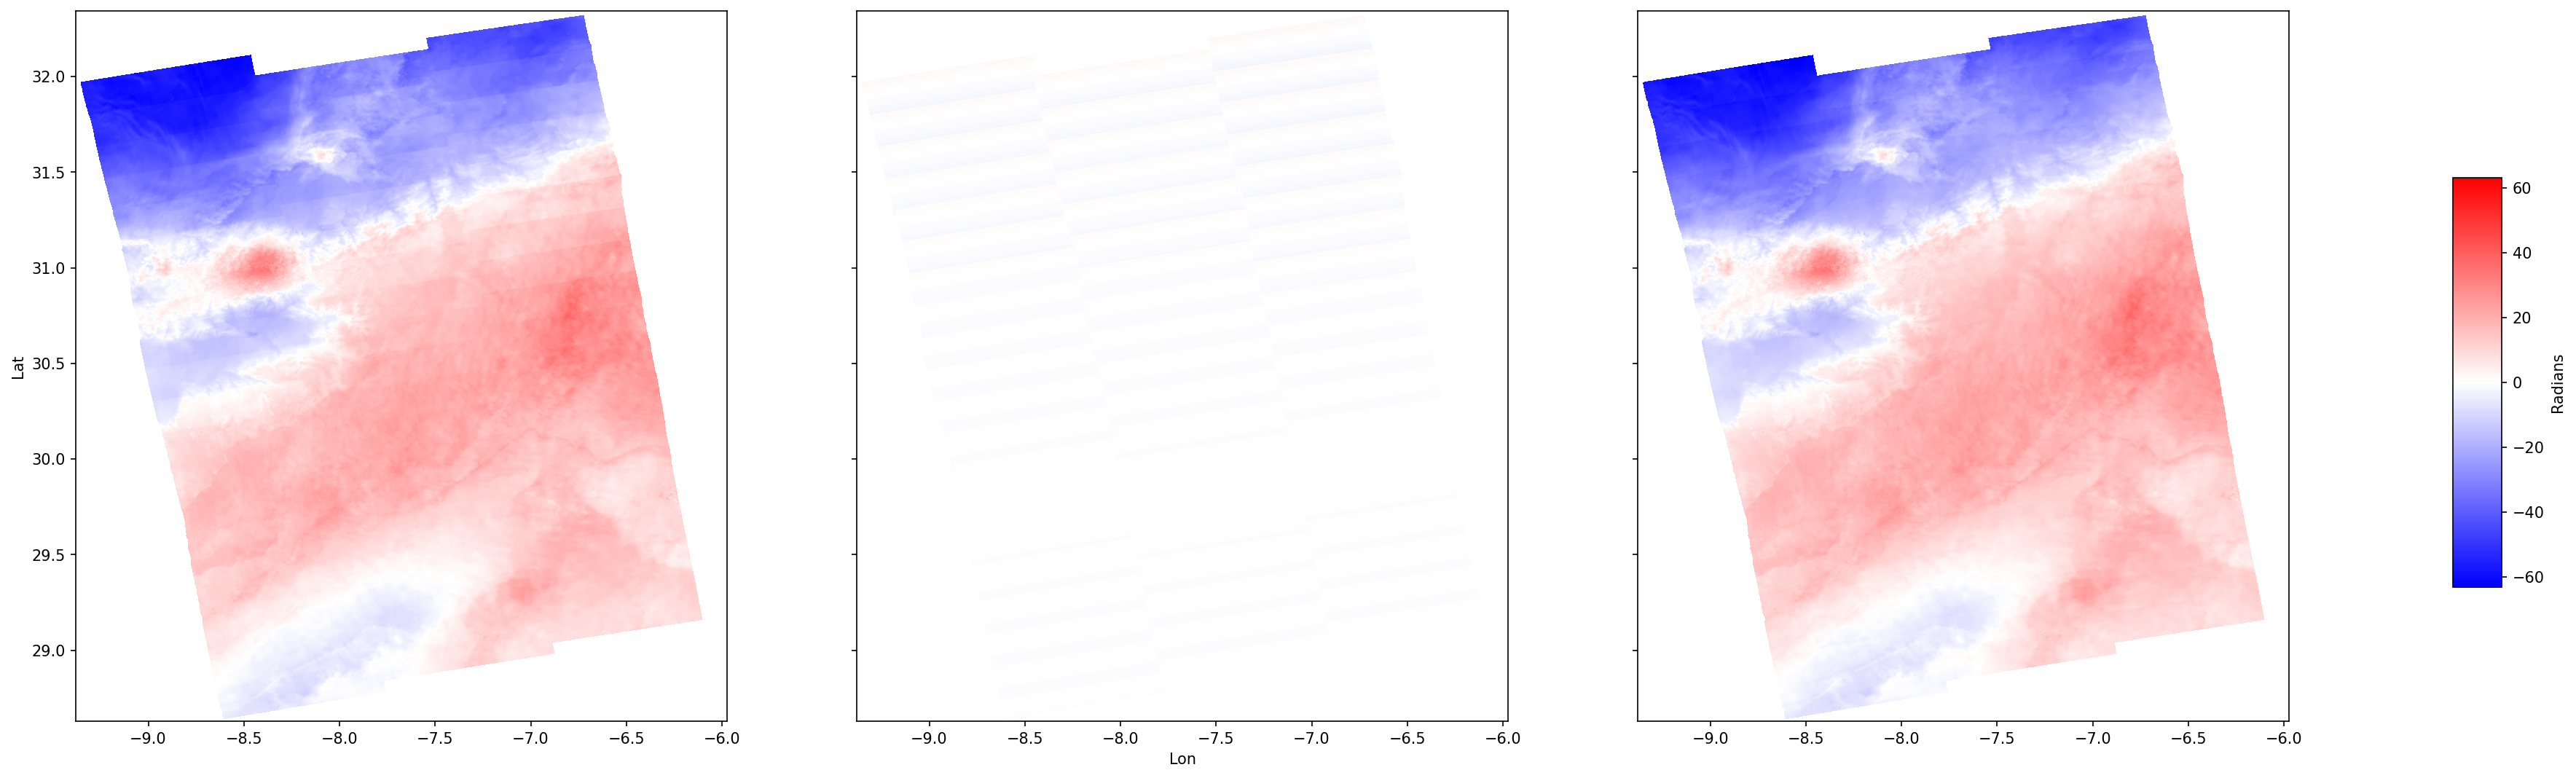

In [10]:
fig, axs = plt.subplots(1, 3, dpi=150, sharey=True, sharex=True, figsize=(30, 15))
cmap='bwr'

v = max(np.nanmax(np.abs(ion)), np.nanmax(np.abs(unw)))
out = show(unw, transform=p_unw['transform'], ax=axs[0], vmin=-v, vmax=v, cmap=cmap)
axs[0].set_ylabel('Lat')
im = out.get_images()[0]

show(corr, transform=p_ion_r['transform'], ax=axs[1], vmin=-v, vmax=v, cmap=cmap)
axs[1].set_xlabel('Lon')
show(unw - corr, transform=p_ion_r['transform'], ax=axs[2], vmin=-v, vmax=v, cmap=cmap)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.36, 0.015, 0.25])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('Radians')